# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

**It represents a single marketing campaign focused on term deposit subscription by clients.**

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [82]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import time

In [83]:
market_campaign = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [84]:
market_campaign.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


## Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



### Data Understanding

* No missing values are present in the dataset. Therefore, no records need to be dropped during preprocessing.
* The target attribute is highly imbalanced with 4640 count for yes responses and 36,458 count for no responses.
* The dataset exhibits a strong class imbalance, with only a small proportion of clients subscribing to a term deposit. As a result, model evaluation should prioritize recall, precision, and F1-score over accuracy to ensure meaningful predictive performance.

* After carefully looking at the data of all the attributes, they can be dividied in to client attributes, campaign communication, campaign history and economic indicator attributes
* Client  profile attributes(age,job,marital,education,default,housing,loan)- Provides client information on who accepted the term deposit
* Campaign communication attrubutes (contact, month, day_of_week, duration) - Helps understand how were subscribers engaged previously
* Duration attribute is only  availablea t the time of client engagement and highly predictive, this feature cannot be used as we will not have future calls duration data
* Campaign history attributes (campaign, pdays, previous, poutcome) - Provides what happened before
* Economic indicators (emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed) - Provides What ecomomic conditions were favourable. Also, interesting would be to know if there is any multicolineraity introduced based on economic indicators
* Below are categorical and numeric features that are identified from the dataset
    * Categorical features: job, marital, education, default, housing, loan, contact, month,day_of_week, poutcome
    * Numeric features: age, campaign, pdays, previous,emp.var.rate, cons.price.idx,cons.conf.idx, euribor3m, nr.employed

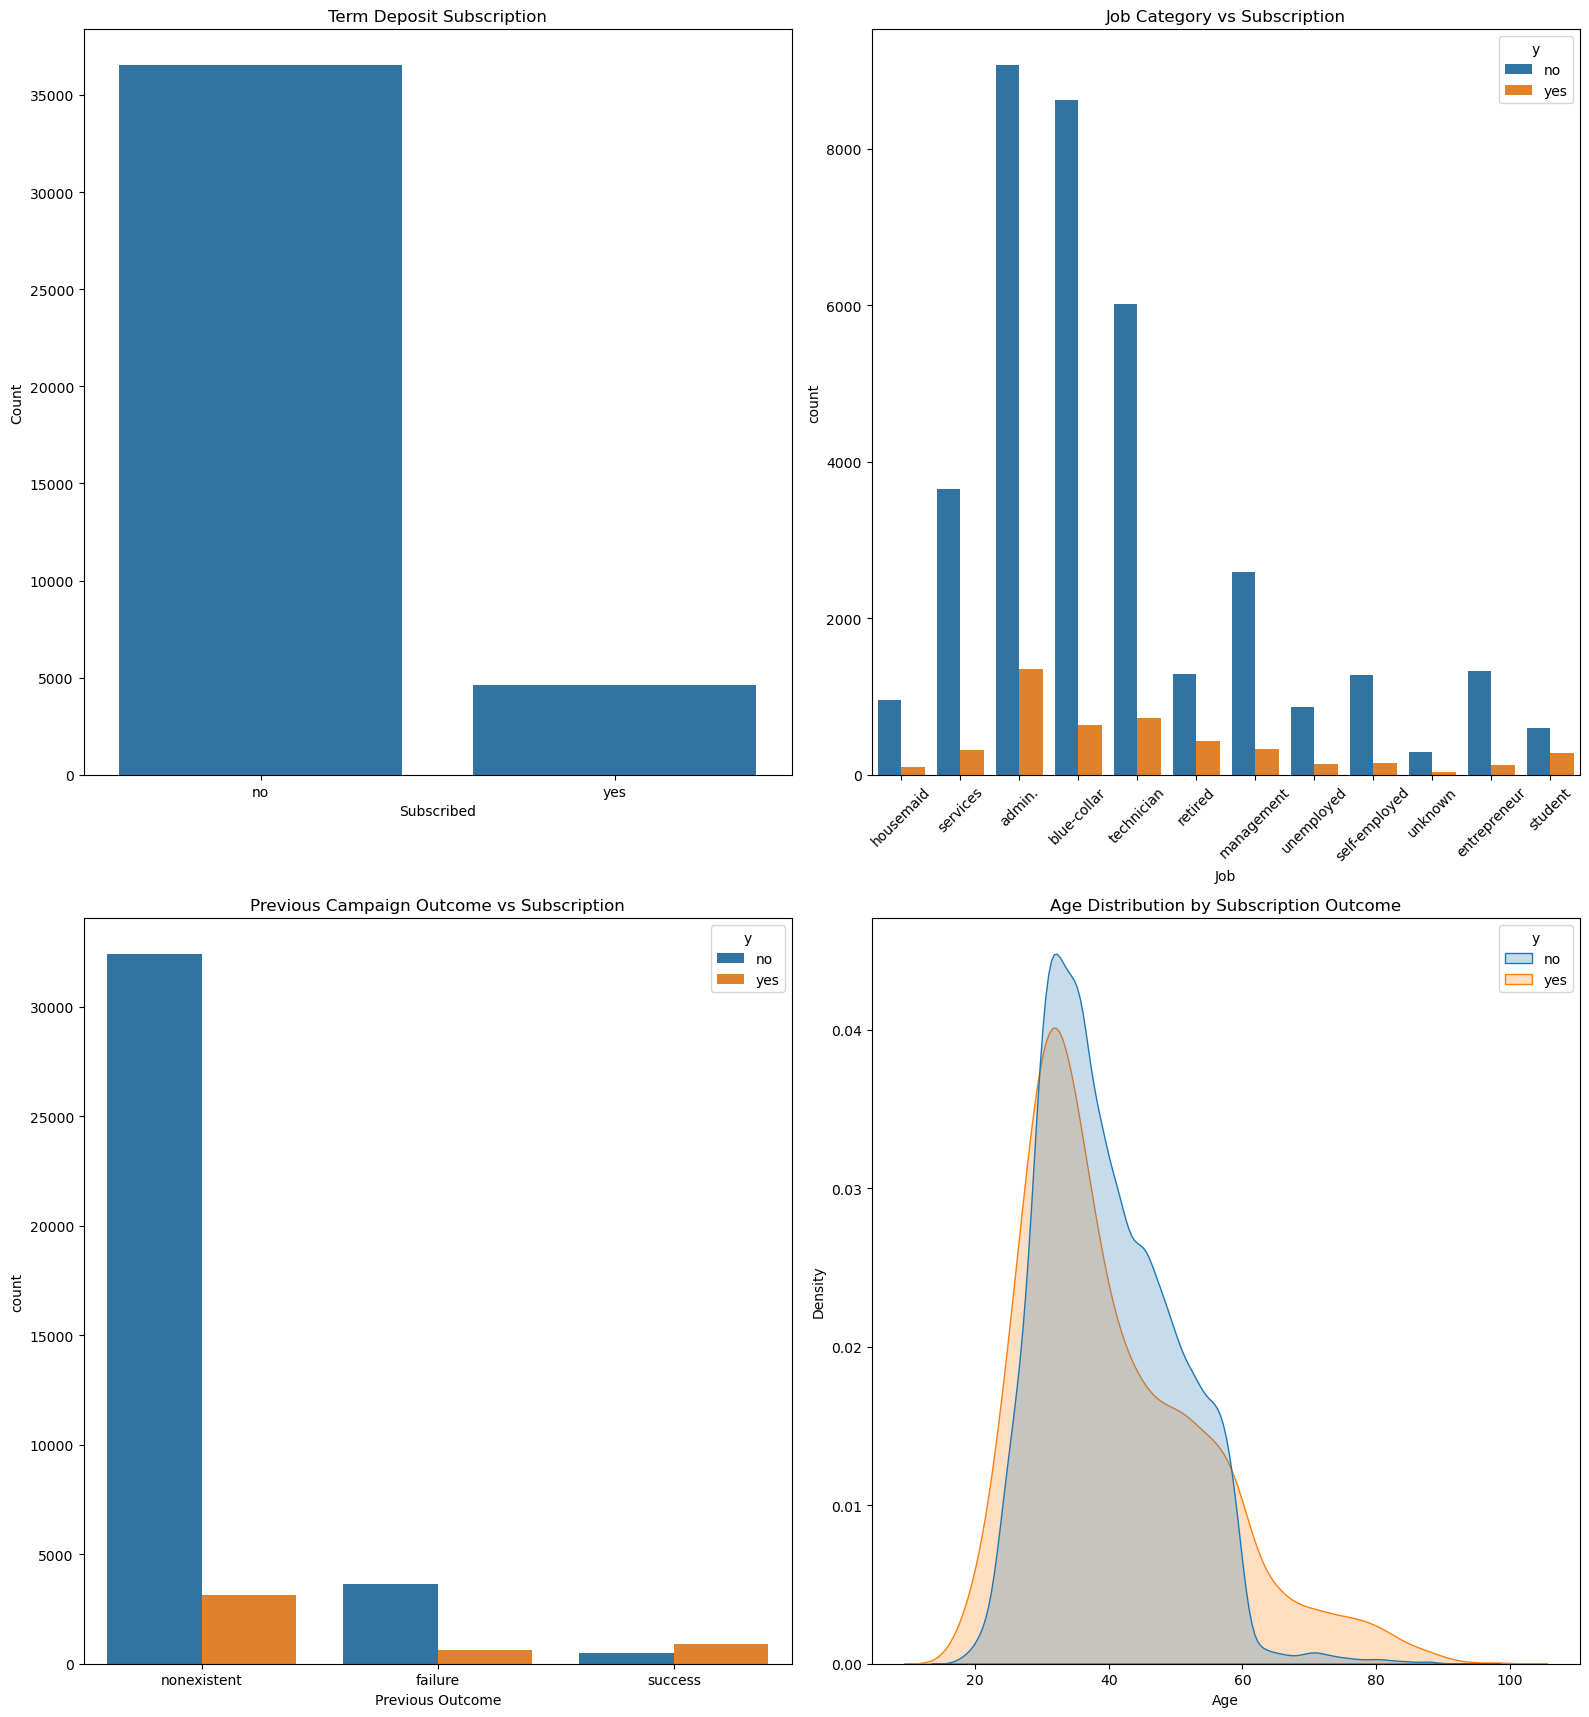

In [149]:
# Visualization of multiple features in relation to subscription
fig, axes = plt.subplots(2, 2, figsize=(16, 18))

# Plot for count of subscription
sns.countplot(data=market_campaign, x="y", ax=axes[0,0])
axes[0, 0].set_title("Term Deposit Subscription")
axes[0, 0].set_xlabel("Subscribed")
axes[0, 0].set_ylabel("Count")

# Plot for job vs subscription
sns.countplot(
    data=market_campaign,
    x="job",
    hue="y",
    ax=axes[0,1]
)
axes[0, 1].set_title("Job Category vs Subscription")
axes[0, 1].tick_params(axis="x", rotation=45)
axes[0, 1].set_xlabel("Job")

# plot for campaign outcome vs subscription
sns.countplot(
    data=market_campaign,
    x="poutcome",
    hue="y",
    ax=axes[1, 0]
)
axes[1, 0].set_title("Previous Campaign Outcome vs Subscription")
axes[1, 0].set_xlabel("Previous Outcome")

# plot for age distribution vs subscription
sns.kdeplot(
    data=market_campaign,
    x="age",
    hue="y",
    fill=True,
    common_norm=False,
    ax=axes[1, 1]
)
axes[1, 1].set_title("Age Distribution by Subscription Outcome")
axes[1, 1].set_xlabel("Age")


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("images/data_understanding_visuals.png", dpi=300,bbox_inches="tight")
plt.show()



### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

## Business Objective

The objective of this task is to evaluate how effectively client and campaign attributes from phone based marketing interactions can be used to predict whether a client will subscribe for a term deposit. This will be assessed  by comparing the which of the  K- Nearest Neighbors(KNN), Logistic Regression, Decision Trees and Support Vector MAchines(SVM) classification models can accurately predict term deposit subscription, also identify and use models based on their performance and their characteristics like interpretability, multi colinearity.

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [86]:
#  Below is the list of categorical and numeric features

cat_feats = [
    "job", "marital", "education", "default",
    "housing", "loan", "contact", "month",
    "day_of_week", "poutcome"
]

num_feats = [
    "age", "campaign", "pdays", "previous",
    "emp.var.rate", "cons.price.idx",
    "cons.conf.idx", "euribor3m", "nr.employed"
]

In [87]:
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_feats),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats)
    ]
)

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [154]:
# Separate features and target
X = market_campaign.drop(columns=["y","duration"])
y = market_campaign["y"].map({"no": 0, "yes": 1}).astype(int)

In [155]:
#  Create train, validation and test data sets for inputs and target varibles
# Goal is divide datasets by 70% for training and 30% for testing
#  Used parameter stratify=y to distribute same proportion of yes and no as original dataset
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [90]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, accuracy_score

In [91]:

# Creating a base model and predicting metrics like
# Accuracy, Precision, recall, F1-Score and ROC-AOC
dummy = DummyClassifier(strategy="stratified", random_state=42)
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

In [151]:
#  This function will calculate accuracy score, precision, recall
#  F1-score and ROC AOC and returns individual scores and dataframe with all scores scores
def get_eval_scores(model, modelname, X, y):
    pred_start_time = time.perf_counter()
    y_pred = model.predict(X)
    pred_end_time = time.perf_counter()
    pred_time = pred_end_time - pred_start_time
    acc_score = accuracy_score(y, y_pred)
    # catching subscribers is the goal, predicting no is not of much business value
    prec_yes = precision_score(y, y_pred, pos_label=1)
    recall_yes = recall_score(y, y_pred, pos_label=1)
    f1_yes = f1_score(y, y_pred, pos_label=1)
    
    #  Ensure we get y_prob when probability is set false for SVC as when set to true the execution time rockets
    if hasattr(model, "predict_proba"):
        y_prob = model.predict_proba(X)[:, 1]
    elif hasattr(model, "decision_function"):
        y_prob = model.decision_function(X)
    else:
        y_prob = None
    
    roc_auc_yes = (
        roc_auc_score(y, y_prob) if y_prob is not None else None
    )
    
    eval_columns = [f"{modelname}(yes)", "Value"]
    baseline_metrcis = pd.DataFrame(columns= eval_columns)
    baseline_metrcis.loc[len(baseline_metrcis)]=["Accuracy", acc_score]
    baseline_metrcis.loc[len(baseline_metrcis)]=["Precision", prec_yes]
    baseline_metrcis.loc[len(baseline_metrcis)]=["Recall", recall_yes]
    baseline_metrcis.loc[len(baseline_metrcis)]=["F1 Score", f1_yes]
    baseline_metrcis.loc[len(baseline_metrcis)]=["ROC AUC", roc_auc_yes]
    # return prec_yes, recall_yes, f1_yes, roc_auc_yes
    return {
        "predict_time": pred_time,
        "accuracy": acc_score,
        "precision": prec_yes,
        "recall": recall_yes,
        "f1": f1_yes,
        "roc_auc": roc_auc_yes,
        "eval metrcis":baseline_metrcis
    }

In [152]:
baseline_metrcis = get_eval_scores(dummy, "Dummy Classifier", X_test, y_test)
baseline_metrcis["eval metrcis"]


,Dummy Classifier(yes),Value
0,Accuracy,0.802703
1,Precision,0.118248
2,Recall,0.116379
3,F1 Score,0.117306
4,ROC AUC,0.503105


### Accuracy of base model is approximately 80%

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [156]:
simp_lgr_pipe =  Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression())
])
simp_lgr_pipe.fit(X_train, y_train)
simp_lgr_metrics = get_eval_scores(simp_lgr_pipe, "Simple LogReg", X_test, y_test)
simp_lgr_metrics["eval metrcis"]

,Simple LogReg(yes),Value
0,Accuracy,0.901271
1,Precision,0.697248
2,Recall,0.218391
3,F1 Score,0.332604
4,ROC AUC,0.803434


### Problem 9: Score the Model

What is the accuracy of your model?


**Accuracy of base model is approximately 90%, while Recall is low loosing potential subscribers**

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [95]:
model_comp_cols = ["Model","Train Time","Train Accuracy","Test Accuracy"] 
model_comp_metrics = pd.DataFrame(columns=model_comp_cols)
model_comp_other_cols = [
    "Model","Train Time",
    "Pred Time","Accuracy", "Precision",
    "Recall", "F1", "ROC AUC"] 
model_comp_more_metrics = pd.DataFrame(columns=model_comp_other_cols)


models = [
    LogisticRegression(), 
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    SVC(probability=False)
]
for model in models:
    pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    start_time = time.perf_counter()
    pipe.fit(X_train, y_train)
    end_time = time.perf_counter()
    train_time = end_time - start_time
    model_name = model.__class__.__name__
    train_acc_score = pipe.score(X_train, y_train)
    test_scores= get_eval_scores(pipe, model_name, X_test, y_test)
    model_comp_metrics.loc[len(model_comp_metrics)]=[
        model_name, 
        train_time, 
        train_acc_score,
        test_scores["accuracy"]
    ] 
    model_comp_more_metrics.loc[len(model_comp_more_metrics)]=[
        model_name, 
        train_time, 
        test_scores["predict_time"],
        test_scores["accuracy"],
        test_scores["precision"],
        test_scores["recall"],
        test_scores["f1"],
        test_scores["roc_auc"]
    ]    
model_comp_metrics

,Model,Train Time,Train Accuracy,Test Accuracy
0,LogisticRegression,0.118091,0.899726,0.901271
1,KNeighborsClassifier,0.035662,0.910860,0.895363
2,DecisionTreeClassifier,0.128053,0.996185,0.839120
3,SVC,22.315289,0.904651,0.902646


In [96]:
model_comp_more_metrics

,Model,Train Time,Pred Time,Accuracy,Precision,Recall,F1,ROC AUC
0,LogisticRegression,0.118091,0.011381,0.901271,0.697248,0.218391,0.332604,0.803434
1,KNeighborsClassifier,0.035662,0.174115,0.895363,0.568655,0.294540,0.388074,0.741108
2,DecisionTreeClassifier,0.128053,0.010760,0.839120,0.310673,0.351293,0.329737,0.627894
3,SVC,22.315289,6.620878,0.902646,0.686391,0.250000,0.366509,0.706101


### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.


- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

###  Hyper Parameter (HP) Optimization
Comparing multiple hyperparameters for Logistic Regression, KNN, Decision tree and SVC models

In [97]:
grid_eval_params = [
    "Model","HyperParams", "Train Time",
    "Pred Time","Accuracy", "Precision",
    "Recall", "F1", "ROC AUC"
] 

gridcv_eval = pd.DataFrame(columns = grid_eval_params)

logreg_coefs= []
def get_coef_df(pipe, model_name):
    feature_names = (
        pipe.named_steps["preprocessor"]
        .get_feature_names_out()
    )
    
    coefs = pipe.named_steps["model"].coef_[0]
    
    logreg_coef = pd.DataFrame({
        "Feature": feature_names,
        model_name: coefs,
        f"{model_name}_OR": np.exp(coefs)
    })
    logreg_coefs.append(logreg_coef)

In [98]:

def logreg_params(feat_engg, gridcv_eval, preprocessor, prX_train, y_train,X_test, y_test):
    logreg_pipe =  Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", LogisticRegression())
    ])
    
    param_grid = {
        "model__C": [0.01, 0.1, 1, 10],
        "model__penalty": ["l2"],
        "model__class_weight": [None, "balanced"]
    }
    
    logreg_grid = GridSearchCV(
        logreg_pipe,
        param_grid,
        scoring="roc_auc",
        cv=5
    )
    logreg_start_time = time.perf_counter()
    logreg_grid.fit(X_train, y_train)
    logreg_end_time = time.perf_counter()
    logreg_train_time = logreg_end_time - logreg_start_time
    best_model = logreg_grid.best_estimator_
    best_params = logreg_grid.best_params_
    model_name = best_model.named_steps["model"].__class__.__name__
    logreg_scores =get_eval_scores(best_model, model_name, X_test, y_test)
    get_coef_df(best_model, f"{feat_engg}_{model_name}")
    gridcv_eval.loc[len(gridcv_eval)] = [
            f"{model_name}_{feat_engg}",
            best_params,
            logreg_train_time, 
            logreg_scores["predict_time"],
            logreg_scores["accuracy"],
            logreg_scores["precision"],
            logreg_scores["recall"],
            logreg_scores["f1"],
            logreg_scores["roc_auc"]
    ]    
    print(gridcv_eval)

In [99]:
def knn_params(feat_engg, gridcv_eval, preprocessor, X_train, y_train,X_test, y_test):
    knn_param_grid = {
        "model__n_neighbors": [5, 7, 11, 15],
        "model__weights": ["uniform", "distance"],
        "model__metric": ["euclidean", "manhattan"]
    }
    
    knn_pipe =  Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", KNeighborsClassifier())
    ])
    
    knn_grid = GridSearchCV(
        knn_pipe,
        knn_param_grid,
        scoring="roc_auc",
        cv=5
    )
    
    knn_start_time = time.perf_counter()
    knn_grid.fit(X_train, y_train)
    knn_end_time = time.perf_counter()
    knn_train_time = knn_end_time - knn_start_time
    best_model = knn_grid.best_estimator_
    best_params = knn_grid.best_params_
    model_name = best_model.named_steps["model"].__class__.__name__
    knn_scores =get_eval_scores(best_model, model_name, X_test, y_test)
    
    gridcv_eval.loc[len(gridcv_eval)] = [
            f"{model_name}_{feat_engg}",
            best_params,
            knn_train_time, 
            knn_scores["predict_time"],
            knn_scores["accuracy"],
            knn_scores["precision"],
            knn_scores["recall"],
            knn_scores["f1"],
            knn_scores["roc_auc"]
    ]    
    print(gridcv_eval)



In [100]:
def dt_params(feat_engg, gridcv_eval, preprocessor, X_train, y_train,X_test, y_test):
    dt_param_grid = {
        "model__max_depth": [None, 5, 10, 15],
        "model__min_samples_split": [2, 10, 20],
        "model__min_samples_leaf": [1, 5, 10],
        "model__criterion": ["gini", "entropy"],
        "model__class_weight": [None, "balanced"]
    }
    
    dt_pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),
        ("model", DecisionTreeClassifier(random_state=42))
    ])
    
    dt_grid = GridSearchCV(
        dt_pipe,
        dt_param_grid,
        scoring="roc_auc",
        cv=5
    )
    
    dt_start_time = time.perf_counter()
    dt_grid.fit(X_train, y_train)
    dt_end_time = time.perf_counter()
    dt_train_time = dt_end_time - dt_start_time
    best_model = dt_grid.best_estimator_
    best_params = dt_grid.best_params_
    model_name = best_model.named_steps["model"].__class__.__name__
    dt_scores =get_eval_scores(best_model, model_name, X_test, y_test)
    
    gridcv_eval.loc[len(gridcv_eval)] = [
            f"{model_name}_{feat_engg}",
            best_params,
            dt_train_time, 
            dt_scores["predict_time"],
            dt_scores["accuracy"],
            dt_scores["precision"],
            dt_scores["recall"],
            dt_scores["f1"],
            dt_scores["roc_auc"]
    ]
    
    print(gridcv_eval)
    

In [101]:
def svc_params(feat_engg, gridcv_eval, preprocessor, X_train, y_train,X_test, y_test):
    svc_param_grid_1 = [
        {
            "model__kernel": ["linear"],
            "model__C": [0.1, 1],
            "model__class_weight": ["balanced"]
        },
        {
            "model__kernel": ["rbf"],
            "model__C": [0.1, 1],
            "model__gamma": ["scale"],
            "model__class_weight": ["balanced"]
        }
    ]
    
    svc_pipe = Pipeline(steps=[
        ("preprocessor", preprocessor),  # includes StandardScaler for numeric feats
        ("model", SVC(probability=False, random_state=42))
    ])
    
    # Tuned some parameters as execution is taking longer
    # Removed model class weight option "None"
    # Opted only [0.1, 1] for C
    #  Reduced folds to 3
    #  use n_jobs=-1 to use all availble cores
    
    svc_grid = GridSearchCV(
        svc_pipe,
        svc_param_grid_1,
        scoring="roc_auc",
        cv=3,          
        n_jobs=-1,     
        verbose=2
    )
    
    svc_start_time = time.perf_counter()
    svc_grid.fit(X_train, y_train)
    svc_end_time = time.perf_counter()
    svc_train_time = svc_end_time - svc_start_time
    best_model = svc_grid.best_estimator_
    best_params = svc_grid.best_params_
    model_name = best_model.named_steps["model"].__class__.__name__
    svc_scores =get_eval_scores(best_model, model_name, X_test, y_test)
    
    
    gridcv_eval.loc[len(gridcv_eval)] = [
            f"{model_name}_{feat_engg}",
            best_params,
            svc_train_time, 
            svc_scores["predict_time"],
            svc_scores["accuracy"],
            svc_scores["precision"],
            svc_scores["recall"],
            svc_scores["f1"],
            svc_scores["roc_auc"]
    ]
    
    print(gridcv_eval)



In [102]:
logreg_params("HP", gridcv_eval, preprocessor, X_train, y_train,X_test, y_test)

                   Model                                        HyperParams  \
0  LogisticRegression_HP  {'model__C': 0.1, 'model__class_weight': 'bala...   

   Train Time  Pred Time  Accuracy  Precision    Recall        F1   ROC AUC  
0    3.695565   0.011136  0.831027   0.361022  0.649425  0.464066  0.802742  


In [103]:
knn_params("HP", gridcv_eval, preprocessor, X_train, y_train,X_test, y_test)

                     Model                                        HyperParams  \
0    LogisticRegression_HP  {'model__C': 0.1, 'model__class_weight': 'bala...   
1  KNeighborsClassifier_HP  {'model__metric': 'manhattan', 'model__n_neigh...   

   Train Time  Pred Time  Accuracy  Precision    Recall        F1   ROC AUC  
0    3.695565   0.011136  0.831027   0.361022  0.649425  0.464066  0.802742  
1   14.351153   0.501819  0.897953   0.617174  0.247845  0.353665  0.773141  


In [104]:
dt_params("HP", gridcv_eval, preprocessor, X_train, y_train,X_test, y_test)

                       Model  \
0      LogisticRegression_HP   
1    KNeighborsClassifier_HP   
2  DecisionTreeClassifier_HP   

                                         HyperParams  Train Time  Pred Time  \
0  {'model__C': 0.1, 'model__class_weight': 'bala...    3.695565   0.011136   
1  {'model__metric': 'manhattan', 'model__n_neigh...   14.351153   0.501819   
2  {'model__class_weight': None, 'model__criterio...   61.658339   0.010094   

   Accuracy  Precision    Recall        F1   ROC AUC  
0  0.831027   0.361022  0.649425  0.464066  0.802742  
1  0.897953   0.617174  0.247845  0.353665  0.773141  
2  0.901271   0.664122  0.250000  0.363257  0.790791  


/opt/anaconda3/lib/python3.12/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [105]:
svc_params("HP", gridcv_eval, preprocessor, X_train, y_train,X_test, y_test)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
                       Model  \
0      LogisticRegression_HP   
1    KNeighborsClassifier_HP   
2  DecisionTreeClassifier_HP   
3                     SVC_HP   

                                         HyperParams  Train Time  Pred Time  \
0  {'model__C': 0.1, 'model__class_weight': 'bala...    3.695565   0.011136   
1  {'model__metric': 'manhattan', 'model__n_neigh...   14.351153   0.501819   
2  {'model__class_weight': None, 'model__criterio...   61.658339   0.010094   
3  {'model__C': 0.1, 'model__class_weight': 'bala...   66.646012  13.753405   

   Accuracy  Precision    Recall        F1   ROC AUC  
0  0.831027   0.361022  0.649425  0.464066  0.802742  
1  0.897953   0.617174  0.247845  0.353665  0.773141  
2  0.901271   0.664122  0.250000  0.363257  0.790791  
3  0.846565   0.388791  0.632902  0.481684  0.786206  


In [106]:
gridcv_eval.to_csv('files/model_metrcis_best_params.csv')

In [107]:
gridcv_eval_disp = gridcv_eval.style.set_table_styles([
    {'selector': '', 'props': [('border', '1px solid black')]},
    {'selector': 'td', 'props': [('border', '1px solid black')]},
    {'selector': 'th', 'props': [('border', '1px solid black')]}
])

gridcv_eval_disp

,Model,HyperParams,Train Time,Pred Time,Accuracy,Precision,Recall,F1,ROC AUC
0,LogisticRegression_HP,"{'model__C': 0.1, 'model__class_weight': 'balanced', 'model__penalty': 'l2'}",3.695565,0.011136,0.831027,0.361022,0.649425,0.464066,0.802742
1,KNeighborsClassifier_HP,"{'model__metric': 'manhattan', 'model__n_neighbors': 15, 'model__weights': 'uniform'}",14.351153,0.501819,0.897953,0.617174,0.247845,0.353665,0.773141
2,DecisionTreeClassifier_HP,"{'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 10, 'model__min_samples_split': 2}",61.658339,0.010094,0.901271,0.664122,0.250000,0.363257,0.790791
3,SVC_HP,"{'model__C': 0.1, 'model__class_weight': 'balanced', 'model__gamma': 'scale', 'model__kernel': 'rbf'}",66.646012,13.753405,0.846565,0.388791,0.632902,0.481684,0.786206


## Engineering features

### Modeling with Hyperparameters and Feature Engineering 1 (HP_FE1)
This approach included combing both Hyperparameter evaluation and consolidation of economic indicators

#### Feature Engineering 1 (FE1):Economic Indicators
The employment variation rate(emp.var.rate), Euribor rate (euribor3m), and number of employed individuals(nr.employed)  are highly correlated as they jointly reflect the underlying economic cycle. Including all three introduces multicollinearity (highly correlated), requiring either feature consolidation to ensure stable and interpretable model coefficients.

In [108]:
eco_att = ["emp.var.rate", "euribor3m", "nr.employed"]
scaler = StandardScaler()
eco_std = scaler.fit_transform(market_campaign[eco_att])
market_campaign["eco_conso"] = eco_std.sum(axis=1)
X = market_campaign.drop(columns=["emp.var.rate", "euribor3m", "nr.employed","y","duration"])
y = market_campaign["y"].map({"no": 0, "yes": 1}).astype(int)
# Goal is divide datasets by 70% for training and 30% for testing
#  Used parameter stratify=y to distribute same proportion of yes and no as original dataset
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

cat_feats_fe = [
    "job", "marital", "education", "default",
    "housing", "loan", "contact", "month",
    "day_of_week", "poutcome"
]

num_feats_fe = [
    "age", "campaign", "pdays", "previous",
    "eco_conso", "cons.price.idx",
    "cons.conf.idx"
]
preprocessor_fe1 = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_feats_fe),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_feats_fe)
    ]
)

fe_gridcv_eval = pd.DataFrame(columns = grid_eval_params)

In [109]:
logreg_params("HP_FE1", fe_gridcv_eval, preprocessor_fe1, X_train, y_train,X_test, y_test)

                       Model  \
0  LogisticRegression_HP_FE1   

                                         HyperParams  Train Time  Pred Time  \
0  {'model__C': 0.1, 'model__class_weight': 'bala...    2.211141   0.011074   

   Accuracy  Precision    Recall        F1   ROC AUC  
0  0.825929   0.351584  0.645833  0.455305  0.802062  


In [110]:
knn_params("HP_FE1", fe_gridcv_eval, preprocessor_fe1, X_train, y_train,X_test, y_test)

[CV] END model__C=0.1, model__class_weight=balanced, model__kernel=linear; total time=  20.1s
[CV] END model__C=0.1, model__class_weight=balanced, model__kernel=linear; total time=  20.3s
[CV] END model__C=0.1, model__class_weight=balanced, model__kernel=linear; total time=  20.8s
[CV] END model__C=1, model__class_weight=balanced, model__gamma=scale, model__kernel=rbf; total time=  21.8s
[CV] END model__C=1, model__class_weight=balanced, model__gamma=scale, model__kernel=rbf; total time=  22.0s
[CV] END model__C=0.1, model__class_weight=balanced, model__gamma=scale, model__kernel=rbf; total time=  22.1s
[CV] END model__C=1, model__class_weight=balanced, model__gamma=scale, model__kernel=rbf; total time=  22.4s
[CV] END model__C=0.1, model__class_weight=balanced, model__gamma=scale, model__kernel=rbf; total time=  22.4s
[CV] END model__C=0.1, model__class_weight=balanced, model__gamma=scale, model__kernel=rbf; total time=  22.7s
                         Model  \
0    LogisticRegression_

In [111]:
dt_params("HP_FE1", fe_gridcv_eval, preprocessor_fe1, X_train, y_train,X_test, y_test)

                           Model  \
0      LogisticRegression_HP_FE1   
1    KNeighborsClassifier_HP_FE1   
2  DecisionTreeClassifier_HP_FE1   

                                         HyperParams  Train Time  Pred Time  \
0  {'model__C': 0.1, 'model__class_weight': 'bala...    2.211141   0.011074   
1  {'model__metric': 'manhattan', 'model__n_neigh...  124.266200   1.506564   
2  {'model__class_weight': None, 'model__criterio...   94.745993   0.011648   

   Accuracy  Precision    Recall        F1   ROC AUC  
0  0.825929   0.351584  0.645833  0.455305  0.802062  
1  0.898357   0.636546  0.227730  0.335450  0.771631  
2  0.901837   0.668550  0.255029  0.369215  0.789856  


In [116]:
svc_params("HP_FE1", fe_gridcv_eval, preprocessor_fe1, X_train, y_train,X_test, y_test)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
                           Model  \
0      LogisticRegression_HP_FE1   
1    KNeighborsClassifier_HP_FE1   
2  DecisionTreeClassifier_HP_FE1   
3                     SVC_HP_FE1   

                                         HyperParams  Train Time  Pred Time  \
0  {'model__C': 0.1, 'model__class_weight': 'bala...    2.211141   0.011074   
1  {'model__metric': 'manhattan', 'model__n_neigh...  124.266200   1.506564   
2  {'model__class_weight': None, 'model__criterio...   94.745993   0.011648   
3  {'model__C': 1, 'model__class_weight': 'balanc...  188.893589   7.516686   

   Accuracy  Precision    Recall        F1   ROC AUC  
0  0.825929   0.351584  0.645833  0.455305  0.802062  
1  0.898357   0.636546  0.227730  0.335450  0.771631  
2  0.901837   0.668550  0.255029  0.369215  0.789856  
3  0.837582   0.367742  0.614224  0.460048  0.790370  


In [127]:
fe_gridcv_eval.to_csv("files/fe1_gridcv_eval.csv", index=False)

In [128]:
fe_gridcv_eval_disp = fe_gridcv_eval.style.set_table_styles([
    {'selector': '', 'props': [('border', '1px solid black')]},
    {'selector': 'td', 'props': [('border', '1px solid black')]},
    {'selector': 'th', 'props': [('border', '1px solid black')]}
])

fe_gridcv_eval_disp

,Model,HyperParams,Train Time,Pred Time,Accuracy,Precision,Recall,F1,ROC AUC
0,LogisticRegression_HP_FE1,"{'model__C': 0.1, 'model__class_weight': 'balanced', 'model__penalty': 'l2'}",2.211141,0.011074,0.825929,0.351584,0.645833,0.455305,0.802062
1,KNeighborsClassifier_HP_FE1,"{'model__metric': 'manhattan', 'model__n_neighbors': 15, 'model__weights': 'uniform'}",124.266200,1.506564,0.898357,0.636546,0.227730,0.335450,0.771631
2,DecisionTreeClassifier_HP_FE1,"{'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 5, 'model__min_samples_split': 20}",94.745993,0.011648,0.901837,0.668550,0.255029,0.369215,0.789856
3,SVC_HP_FE1,"{'model__C': 1, 'model__class_weight': 'balanced', 'model__kernel': 'linear'}",188.893589,7.516686,0.837582,0.367742,0.614224,0.460048,0.790370


In [119]:
html = fe_gridcv_eval_disp.to_html()
with open("files/fe1_gridcv_eval.html", "w") as f:
    f.write(html)

## Modeling with Hyperparameters and Feature Engineering 2 (HP_FE2)
This approach included combining both Hyperparameter evaluation and reduction of client profile dimensionality.

## Feature Engineering 2: Simplifying client profile signals
Feature Engineering(FE2) reduces client profile dimensionality by grouping job categories and education levels into economically meaningful tiers, minimizing sparsity and improving coefficient stability. A quadratic age term is introduced to capture non-linear age effects. This approach simplifies feature representation and enhances interpretability without materially increasing model complexity.


In [120]:
market_campaign_fe2 = market_campaign.copy()
market_campaign_fe2["age_sq"] = market_campaign_fe2["age"] ** 2

# Consolidate job categories to reduce sparsity
white_collar = {"admin.", "management", "technician", "entrepreneur"}
blue_collar = {"blue-collar", "services", "housemaid"}
other_jobs = {"self-employed", "unemployed", "unknown"}

def map_job(job):
    if job in white_collar:
        return "white_collar"
    elif job in blue_collar:
        return "blue_collar"
    elif job == "retired":
        return "retired"
    elif job == "student":
        return "student"
    else:
        return "other"

market_campaign_fe2["job_grp"] = market_campaign_fe2["job"].apply(map_job)

# Consolidate educational tiers to reduce sparsity
basic_edu = {"basic.4y", "basic.6y", "basic.9y"}
secondary_edu = {"high.school", "professional.course"}
higher_edu = {"university.degree"}

def map_education(edu):
    if edu in basic_edu:
        return "basic"
    elif edu in secondary_edu:
        return "secondary"
    elif edu in higher_edu:
        return "higher"
    else:
        return "unknown"

market_campaign_fe2["edu_tier"] = market_campaign_fe2["education"].apply(map_education)
X = market_campaign_fe2.drop(columns=[ "age","job", "education","y","duration"])
y = market_campaign_fe2["y"].map({"no": 0, "yes": 1}).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

cat_feats_fe2 = [
    "marital", "default", "job_grp", "edu_tier",
    "housing", "loan", "contact", "month",
    "day_of_week", "poutcome"
]

num_feats_fe2 = [
    "age_sq", "campaign", "pdays", "previous",
    "emp.var.rate", "cons.price.idx",
    "cons.conf.idx", "euribor3m", "nr.employed"
]

preprocessor_fe2 = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_feats_fe2),
        ("num", StandardScaler(), num_feats_fe2)
    ]
)

In [121]:
fe2_gridcv_eval = pd.DataFrame(columns = grid_eval_params)

In [122]:
logreg_params("HP_FE2", fe2_gridcv_eval, preprocessor_fe2, X_train, y_train,X_test, y_test)

                       Model  \
0  LogisticRegression_HP_FE2   

                                         HyperParams  Train Time  Pred Time  \
0  {'model__C': 0.1, 'model__class_weight': 'bala...    3.566356   0.018776   

   Accuracy  Precision    Recall        F1   ROC AUC  
0  0.832645   0.364039  0.650144  0.466735  0.803499  


In [123]:
knn_params("HP_FE2", fe2_gridcv_eval, preprocessor_fe2, X_train, y_train,X_test, y_test)

                         Model  \
0    LogisticRegression_HP_FE2   
1  KNeighborsClassifier_HP_FE2   

                                         HyperParams  Train Time  Pred Time  \
0  {'model__C': 0.1, 'model__class_weight': 'bala...    3.566356   0.018776   
1  {'model__metric': 'manhattan', 'model__n_neigh...   11.557839   0.335520   

   Accuracy  Precision    Recall        F1   ROC AUC  
0  0.832645   0.364039  0.650144  0.466735  0.803499  
1  0.899328   0.634545  0.250718  0.359423  0.773386  


In [124]:
dt_params("HP_FE2", fe2_gridcv_eval, preprocessor_fe2, X_train, y_train,X_test, y_test)

[CV] END model__C=1, model__class_weight=balanced, model__gamma=scale, model__kernel=rbf; total time=  19.6s
[CV] END model__C=1, model__class_weight=balanced, model__gamma=scale, model__kernel=rbf; total time=  19.6s
[CV] END model__C=1, model__class_weight=balanced, model__gamma=scale, model__kernel=rbf; total time=  19.9s
[CV] END model__C=0.1, model__class_weight=balanced, model__gamma=scale, model__kernel=rbf; total time=  20.1s
[CV] END model__C=0.1, model__class_weight=balanced, model__gamma=scale, model__kernel=rbf; total time=  20.4s
[CV] END model__C=0.1, model__class_weight=balanced, model__gamma=scale, model__kernel=rbf; total time=  20.7s
[CV] END model__C=0.1, model__class_weight=balanced, model__kernel=linear; total time=  25.6s
[CV] END model__C=0.1, model__class_weight=balanced, model__kernel=linear; total time=  26.0s
[CV] END model__C=0.1, model__class_weight=balanced, model__kernel=linear; total time=  26.6s
[CV] END model__C=1, model__class_weight=balanced, model__

In [125]:
svc_params("HP_FE2", fe2_gridcv_eval, preprocessor_fe2, X_train, y_train,X_test, y_test)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
                           Model  \
0      LogisticRegression_HP_FE2   
1    KNeighborsClassifier_HP_FE2   
2  DecisionTreeClassifier_HP_FE2   
3                     SVC_HP_FE2   

                                         HyperParams  Train Time  Pred Time  \
0  {'model__C': 0.1, 'model__class_weight': 'bala...    3.566356   0.018776   
1  {'model__metric': 'manhattan', 'model__n_neigh...   11.557839   0.335520   
2  {'model__class_weight': None, 'model__criterio...   57.300577   0.013003   
3  {'model__C': 1, 'model__class_weight': 'balanc...   46.230085   9.648257   

   Accuracy  Precision    Recall        F1   ROC AUC  
0  0.832645   0.364039  0.650144  0.466735  0.803499  
1  0.899328   0.634545  0.250718  0.359423  0.773386  
2  0.900947   0.660305  0.248563  0.361169  0.790384  
3  0.850935   0.398282  0.632902  0.488901  0.787226  


In [126]:
fe2_gridcv_eval.to_csv("files/fe2_gridcv_eval.csv", index=False)
fe2_gridcv_eval_disp = fe2_gridcv_eval.style.set_table_styles([
    {'selector': '', 'props': [('border', '1px solid black')]},
    {'selector': 'td', 'props': [('border', '1px solid black')]},
    {'selector': 'th', 'props': [('border', '1px solid black')]}
])

fe2_gridcv_eval_disp

,Model,HyperParams,Train Time,Pred Time,Accuracy,Precision,Recall,F1,ROC AUC
0,LogisticRegression_HP_FE2,"{'model__C': 0.1, 'model__class_weight': 'balanced', 'model__penalty': 'l2'}",3.566356,0.018776,0.832645,0.364039,0.650144,0.466735,0.803499
1,KNeighborsClassifier_HP_FE2,"{'model__metric': 'manhattan', 'model__n_neighbors': 15, 'model__weights': 'uniform'}",11.557839,0.335520,0.899328,0.634545,0.250718,0.359423,0.773386
2,DecisionTreeClassifier_HP_FE2,"{'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 10, 'model__min_samples_split': 2}",57.300577,0.013003,0.900947,0.660305,0.248563,0.361169,0.790384
3,SVC_HP_FE2,"{'model__C': 1, 'model__class_weight': 'balanced', 'model__gamma': 'scale', 'model__kernel': 'rbf'}",46.230085,9.648257,0.850935,0.398282,0.632902,0.488901,0.787226


## Modeling with Hyperparameters and Feature Engineering including 1 and 2 (HP_FE12)
This approach combined  all Hyperparameter evaluation, consolidation of economic indicators and reduction of client profile dimensionality. Key evaluation metrics are shown below.
## Feature Engineering (FE12 = FE1 + FE2): Client Profile and Economic Signal Optimization
FE1 and FE2 together focus on improving model stability and interpretability by refining both client profile and streamlining macroeconomic indicators are streamlined to represent overall economic conditions without introducing multicollinearity.Combined, these steps reduce dimensionality, stabilize coefficients in linear models, and preserve meaningful behavioral and economic signals for predicting term deposit subscription.

In [132]:
market_campaign_fe12 = market_campaign.copy()
market_campaign_fe12["eco_conso"] = eco_std.sum(axis=1)
market_campaign_fe12["age_sq"] = market_campaign_fe12["age"] ** 2
market_campaign_fe12["edu_tier"] = market_campaign_fe12["education"].apply(map_education)
market_campaign_fe12["job_grp"] = market_campaign_fe12["job"].apply(map_job)

X = market_campaign_fe12.drop(columns=[ "age","job", "education","emp.var.rate", "euribor3m", "nr.employed","y","duration"])
y = market_campaign_fe12["y"].map({"no": 0, "yes": 1}).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

cat_feats_fe12 = [
    "marital", "default", "job_grp", "edu_tier",
    "housing", "loan", "contact", "month",
    "day_of_week", "poutcome"
]

num_feats_fe12 = [
    "age_sq", "campaign", "pdays", "previous",
    "cons.price.idx", "cons.conf.idx", "eco_conso"
]

preprocessor_fe12 = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_feats_fe12),
        ("num", StandardScaler(), num_feats_fe12)
    ]
)


In [133]:
fe12_gridcv_eval = pd.DataFrame(columns = grid_eval_params)

In [134]:
logreg_params("HP_FE12", fe12_gridcv_eval, preprocessor_fe12, X_train, y_train,X_test, y_test)

                        Model  \
0  LogisticRegression_HP_FE12   

                                         HyperParams  Train Time  Pred Time  \
0  {'model__C': 0.1, 'model__class_weight': 'bala...    3.549389   0.019133   

   Accuracy  Precision   Recall        F1   ROC AUC  
0  0.827952   0.355284  0.64727  0.458758  0.803016  


In [135]:
knn_params("HP_FE12", fe12_gridcv_eval, preprocessor_fe12, X_train, y_train,X_test, y_test)

                          Model  \
0    LogisticRegression_HP_FE12   
1  KNeighborsClassifier_HP_FE12   

                                         HyperParams  Train Time  Pred Time  \
0  {'model__C': 0.1, 'model__class_weight': 'bala...    3.549389   0.019133   
1  {'model__metric': 'manhattan', 'model__n_neigh...   11.150646   0.329186   

   Accuracy  Precision    Recall        F1   ROC AUC  
0  0.827952   0.355284  0.647270  0.458758  0.803016  
1  0.898357   0.630769  0.235632  0.343096  0.772222  


In [136]:
dt_params("HP_FE12", fe12_gridcv_eval, preprocessor_fe12, X_train, y_train,X_test, y_test)

                            Model  \
0      LogisticRegression_HP_FE12   
1    KNeighborsClassifier_HP_FE12   
2  DecisionTreeClassifier_HP_FE12   

                                         HyperParams  Train Time  Pred Time  \
0  {'model__C': 0.1, 'model__class_weight': 'bala...    3.549389   0.019133   
1  {'model__metric': 'manhattan', 'model__n_neigh...   11.150646   0.329186   
2  {'model__class_weight': None, 'model__criterio...   56.443299   0.013221   

   Accuracy  Precision    Recall        F1   ROC AUC  
0  0.827952   0.355284  0.647270  0.458758  0.803016  
1  0.898357   0.630769  0.235632  0.343096  0.772222  
2  0.901837   0.669187  0.254310  0.368558  0.790383  


In [137]:
svc_params("HP_FE12", fe12_gridcv_eval, preprocessor_fe12, X_train, y_train,X_test, y_test)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] END model__C=0.1, model__class_weight=balanced, model__kernel=linear; total time=  12.2s
[CV] END model__C=0.1, model__class_weight=balanced, model__kernel=linear; total time=  12.7s
                            Model  \
0      LogisticRegression_HP_FE12   
1    KNeighborsClassifier_HP_FE12   
2  DecisionTreeClassifier_HP_FE12   
3                     SVC_HP_FE12   

                                         HyperParams  Train Time  Pred Time  \
0  {'model__C': 0.1, 'model__class_weight': 'bala...    3.549389   0.019133   
1  {'model__metric': 'manhattan', 'model__n_neigh...   11.150646   0.329186   
2  {'model__class_weight': None, 'model__criterio...   56.443299   0.013221   
3  {'model__C': 1, 'model__class_weight': 'balanc...  108.557655   2.793266   

   Accuracy  Precision    Recall        F1   ROC AUC  
0  0.827952   0.355284  0.647270  0.458758  0.803016  
1  0.898357   0.630769  0.235632  0.343096  0.772222  
2  0.

In [138]:
fe12_gridcv_eval.to_csv("files/fe12_gridcv_eval.csv", index=False)
fe12_gridcv_eval_disp = fe12_gridcv_eval.style.set_table_styles([
    {'selector': '', 'props': [('border', '1px solid black')]},
    {'selector': 'td', 'props': [('border', '1px solid black')]},
    {'selector': 'th', 'props': [('border', '1px solid black')]}
])

fe12_gridcv_eval_disp

,Model,HyperParams,Train Time,Pred Time,Accuracy,Precision,Recall,F1,ROC AUC
0,LogisticRegression_HP_FE12,"{'model__C': 0.1, 'model__class_weight': 'balanced', 'model__penalty': 'l2'}",3.549389,0.019133,0.827952,0.355284,0.647270,0.458758,0.803016
1,KNeighborsClassifier_HP_FE12,"{'model__metric': 'manhattan', 'model__n_neighbors': 15, 'model__weights': 'uniform'}",11.150646,0.329186,0.898357,0.630769,0.235632,0.343096,0.772222
2,DecisionTreeClassifier_HP_FE12,"{'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 5, 'model__min_samples_split': 20}",56.443299,0.013221,0.901837,0.669187,0.254310,0.368558,0.790383
3,SVC_HP_FE12,"{'model__C': 1, 'model__class_weight': 'balanced', 'model__kernel': 'linear'}",108.557655,2.793266,0.837582,0.367742,0.614224,0.460048,0.790852


In [143]:
# Concatenating all results for evaluation

comp_gridcv_eval_fe = pd.concat(
    [
        gridcv_eval,
        fe_gridcv_eval,
        fe2_gridcv_eval,
        fe12_gridcv_eval
    ],
    axis=0,
    ignore_index=True
)

comp_gridcv_eval_fe.to_csv("comp_gridcv_eval_fe.csv", index=False)
comp_gridcv_eval_fe_disp = comp_gridcv_eval_fe.style.set_table_styles([
    {'selector': '', 'props': [('border', '1px solid black')]},
    {'selector': 'td', 'props': [('border', '1px solid black')]},
    {'selector': 'th', 'props': [('border', '1px solid black')]}
])

comp_gridcv_eval_fe_disp

,Model,HyperParams,Train Time,Pred Time,Accuracy,Precision,Recall,F1,ROC AUC
0,LogisticRegression_HP,"{'model__C': 0.1, 'model__class_weight': 'balanced', 'model__penalty': 'l2'}",3.695565,0.011136,0.831027,0.361022,0.649425,0.464066,0.802742
1,KNeighborsClassifier_HP,"{'model__metric': 'manhattan', 'model__n_neighbors': 15, 'model__weights': 'uniform'}",14.351153,0.501819,0.897953,0.617174,0.247845,0.353665,0.773141
2,DecisionTreeClassifier_HP,"{'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 10, 'model__min_samples_split': 2}",61.658339,0.010094,0.901271,0.664122,0.250000,0.363257,0.790791
3,SVC_HP,"{'model__C': 0.1, 'model__class_weight': 'balanced', 'model__gamma': 'scale', 'model__kernel': 'rbf'}",66.646012,13.753405,0.846565,0.388791,0.632902,0.481684,0.786206
4,LogisticRegression_HP_FE1,"{'model__C': 0.1, 'model__class_weight': 'balanced', 'model__penalty': 'l2'}",2.211141,0.011074,0.825929,0.351584,0.645833,0.455305,0.802062
5,KNeighborsClassifier_HP_FE1,"{'model__metric': 'manhattan', 'model__n_neighbors': 15, 'model__weights': 'uniform'}",124.266200,1.506564,0.898357,0.636546,0.227730,0.335450,0.771631
6,DecisionTreeClassifier_HP_FE1,"{'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 5, 'model__min_samples_leaf': 5, 'model__min_samples_split': 20}",94.745993,0.011648,0.901837,0.668550,0.255029,0.369215,0.789856
7,SVC_HP_FE1,"{'model__C': 1, 'model__class_weight': 'balanced', 'model__kernel': 'linear'}",188.893589,7.516686,0.837582,0.367742,0.614224,0.460048,0.790370
8,LogisticRegression_HP_FE2,"{'model__C': 0.1, 'model__class_weight': 'balanced', 'model__penalty': 'l2'}",3.566356,0.018776,0.832645,0.364039,0.650144,0.466735,0.803499
9,KNeighborsClassifier_HP_FE2,"{'model__metric': 'manhattan', 'model__n_neighbors': 15, 'model__weights': 'uniform'}",11.557839,0.335520,0.899328,0.634545,0.250718,0.359423,0.773386


In [140]:
html = comp_gridcv_eval_fe_disp.to_html()
with open("files/comp_gridcv_eval_fe_disp.html", "w") as f:
    f.write(html)

In [141]:
coef_all = pd.concat(logreg_coefs, axis=0, ignore_index=True)
coef_all_df = coef_all.copy()
coef_all.to_csv("files/coef_all.csv", index=False)
coef_all

,Feature,HP_LogisticRegression,HP_LogisticRegression_OR,HP_FE1_LogisticRegression,HP_FE1_LogisticRegression_OR,HP_FE2_LogisticRegression,HP_FE2_LogisticRegression_OR,HP_FE12_LogisticRegression,HP_FE12_LogisticRegression_OR
0,num__age,-0.008283,0.991751,NaN,NaN,NaN,NaN,NaN,NaN
1,num__campaign,-0.121523,0.885571,NaN,NaN,NaN,NaN,NaN,NaN
2,num__pdays,-0.278284,0.757082,NaN,NaN,NaN,NaN,NaN,NaN
3,num__previous,-0.078474,0.924526,NaN,NaN,NaN,NaN,NaN,NaN
4,num__emp.var.rate,-1.500585,0.223000,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
236,num__pdays,NaN,NaN,NaN,NaN,NaN,NaN,-0.300012,0.740809
237,num__previous,NaN,NaN,NaN,NaN,NaN,NaN,-0.080414,0.922735
238,num__cons.price.idx,NaN,NaN,NaN,NaN,NaN,NaN,0.242252,1.274115
239,num__cons.conf.idx,NaN,NaN,NaN,NaN,NaN,NaN,0.153305,1.165681


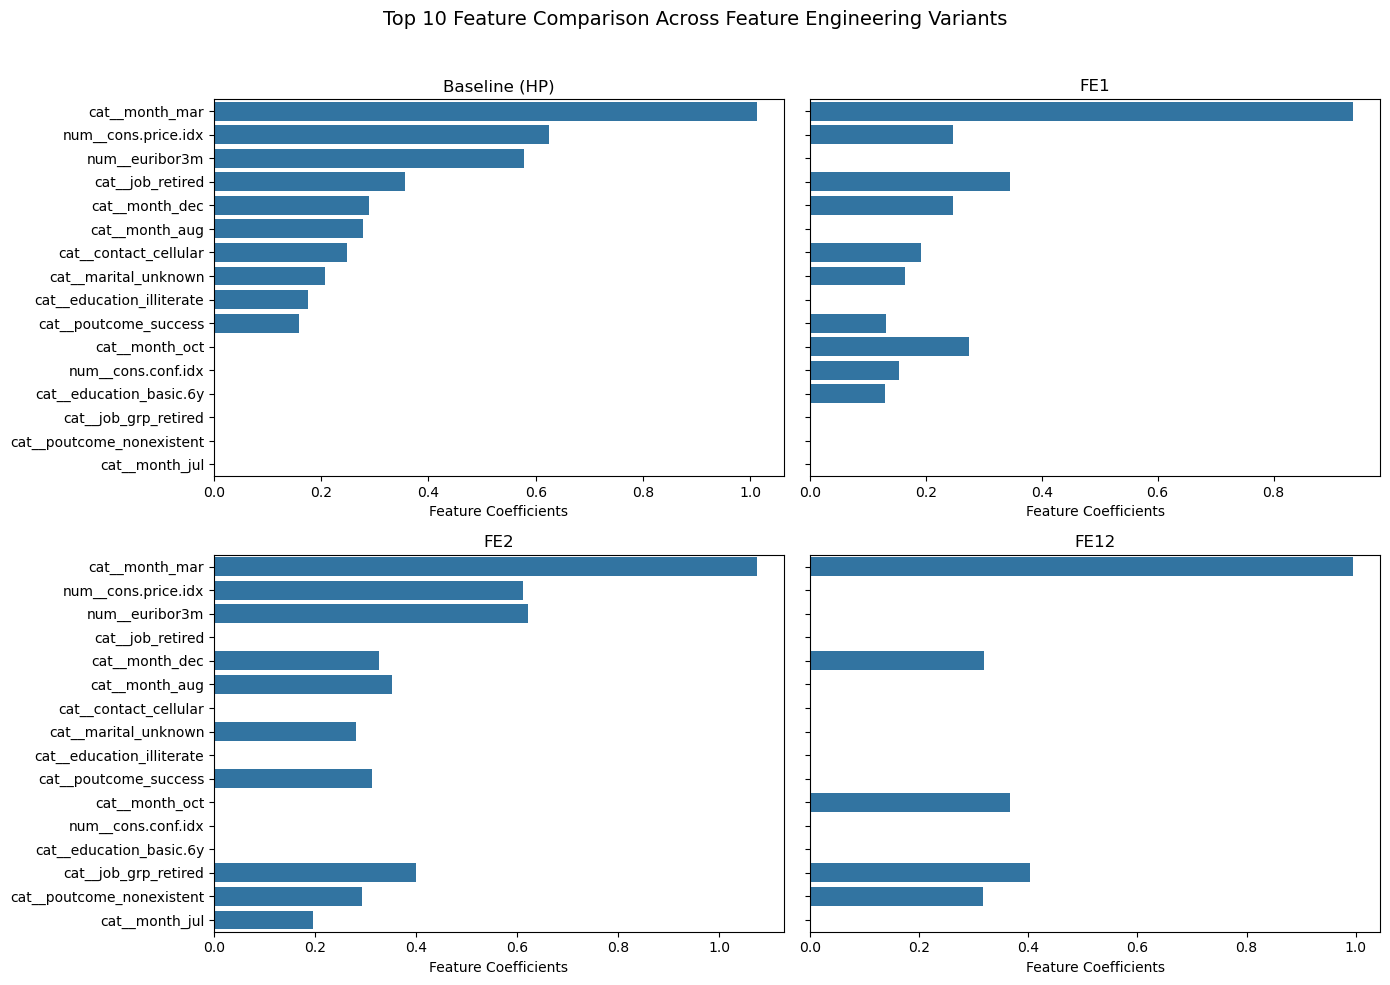

In [142]:

# Plotting the coefficents for interpretation

impact_configs = [
    ("HP_LogisticRegression", "Baseline (HP)"),
    ("HP_FE1_LogisticRegression", "FE1"),
    ("HP_FE2_LogisticRegression", "FE2"),
    ("HP_FE12_LogisticRegression", "FE12"),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharey=True)

for ax, (col, title) in zip(axes.flatten(), impact_configs):

    top10_feats = (
        coef_all
        .sort_values(col, ascending=False)
        .head(10)
    )   
    
    sns.barplot(
        data=top10_feats,
        x=col,
        y="Feature",
        ax=ax
    )
    ax.set_title(title)
    ax.set_xlabel("Feature Coefficients")
    ax.set_ylabel("")

plt.suptitle("Top 10 Feature Comparison Across Feature Engineering Variants",
             fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(
    "top10_feature_comparison_across_FEs.png",
    dpi=300,
    bbox_inches="tight"
)
plt.show()

### Interpretation of coefficients
#### Logistic Regression
* Provides a direct and interpretable relationship between features and the outcome, with explicit coefficient magnitudes indicating the direction and strength of impact. Hence, Logistic Regression is preferred for interpretation due to its stable and directly explainable coefficients, unlike the other models that are evaluated.
#### KNN
* Predictions depend on nearby data points and do not provide a clear explanation of individual feature impact.
#### SVC
* Decisions are made in a complex mathematical space, making feature-level interpretation difficult and less transparent.
#### Decision Tree
* Overall performance metrics are not comparable to Logistic Regression for this problem, and decision paths and feature importance can change across runs, reducing interpretability. Based on these limitations, decision trees were not used for coefficient-level interpretation.

## Model by Model Interpretation

### Logistic Regression

* Consistently achieves the best ROC–AUC across Base, FE1, FE2, and FE12, indicating the strongest ranking ability.
* Maintains high recall, effectively capturing most potential subscribers, which aligns with the business objective.
* Fastest model in both training and inference across all feature sets.
* Provides clear coefficient interpretability, making it suitable for explaining drivers of subscription behavior.
* Feature engineering marginally improves stability but does not materially change performance.

### SVC

* Achieves competitive F1 scores and high recall, indicating good classification strength.
* ROC–AUC is consistently strong but does not outperform Logistic Regression.
* Significantly slower in both training and prediction.
* Limited interpretability and high computational cost reduce its practical appeal despite comparable performance with Linear calssification model.

### Decision Tree

* Suffers from low recall, missing a large portion of actual subscribers.
* Training and inference are fast, but performance remains relatively unchanged across feature engineering variants.
* Suitable for rule extraction, but not optimal for the primary goal of subscriber identification.

### KNN
* Very low recall, making it ineffective for identifying subscribers, though accuracy is high and comparable with other classifiers.
* Accuracy is misleading given the class imbalance.
* Lower ROC–AUC compared to Logistic Regression, Decision Trees, and SVC.

## Overall Interpretation
Across all models, Logistic Regression provides the best balance of ranking ability, subscriber recall, interpretability, and computational efficiency. While SVC has comparable predictive strength but performs poorly in terms of execution time. Decision Trees and KNN perform adequately on some metrics but overall fall short on the primary business goal of identifying potential subscribers.

## Conclusion

Logistic Regression emerges as the best-performing model for this dataset. Within Logistic Regression, the FE12 model with hyperparameters (C = 0.1, penalty = L2, class_weight = balanced) is the preferred choice. FE12 consolidates multicollinear economic indicators and aggregates sparse client profile features, resulting in improved coefficient stability, strong recall, and consistent ranking performance.


In [146]:
# Final execution of the chosen Logistic Regression model
X = market_campaign_fe12.drop(columns=[ "age","job", "education","emp.var.rate", "euribor3m", "nr.employed","y","duration"])
y = market_campaign_fe12["y"].map({"no": 0, "yes": 1}).astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.30,
    random_state=42,
    stratify=y
)

f_param_grid = {
    "model__C": [0.1],
    "model__penalty": ["l2"],
    "model__class_weight": ["balanced"]
}

f_logreg_pipe =  Pipeline(steps=[
        ("preprocessor", preprocessor_fe12),
        ("model", LogisticRegression())
    ])

f_logreg_grid = GridSearchCV(
    f_logreg_pipe,
    f_param_grid,
    scoring="roc_auc",
    cv=5
)
f_logreg_start_time = time.perf_counter()
f_logreg_grid.fit(X_train, y_train)
f_logreg_end_time = time.perf_counter()
f_logreg_train_time = f_logreg_end_time - f_logreg_start_time
f_best_model = f_logreg_grid.best_estimator_
f_best_params = f_logreg_grid.best_params_
f_model_name = f_best_model.named_steps["model"].__class__.__name__
f_logreg_scores =get_eval_scores(f_best_model, f"{f_model_name}_HP_FE2", X_test, y_test)
f_eval_metrics = f_logreg_scores["eval metrcis"]
f_eval_metrics.loc[len(f_eval_metrics)] = ["Train Time", f_logreg_train_time]
f_eval_metrics.loc[len(f_eval_metrics)] = ["Pred Time", f_logreg_scores["predict_time"]]
f_eval_metrics

,LogisticRegression_HP_FE2(yes),Value
0,Accuracy,0.827952
1,Precision,0.355284
2,Recall,0.647270
3,F1 Score,0.458758
4,ROC AUC,0.803016
5,Train Time,0.659081
6,Pred Time,0.013904


##### Questions